In [1]:
#TODO - analisar se o Ytest que chega aqui e o Ytest que esta no data score estao corretos

# GUIDELINE
# 1 funcao que testa tudo.

# deveria haver um alinhamento completo das estruturas de dados

# mas nao adianta se eu nao souber o problema que eu quero resolver.

# OBJETIVO - score de presenca. Quantos porcento de produto que tem na prateleira.




# Historico
- Rede dupla e/ou com 100 neuronios: ruim. Nos primeiros passos o resultado fica razoavel, mas quando avanca piora.
- Rede unica com 10 neuronios: bom.

In [1]:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
import sys 
import json
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph 
import math
import collections
import pandas as pd

## for Deep-learing:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import model_from_json
from tensorflow.python.keras.callbacks import TensorBoard

from itertools import product
from functools import partial
from time import time

from core.DataExploration import DataExploration
from core.ModelIndicators import ModelIndicators
from ruptura.CreateBatch import CreateBatch
from ruptura.RupturaPrediction import RupturaPrediction
from ruptura.RupturaNeuralNetwork import RupturaNeuralNetwork

def defineLossWeights(yUnknow):
    weigths = []
    for y in yUnknow:
        if y == 0:
            weigths.append(1)
        else:
            weigths.append(0.1)
    return weigths


Using TensorFlow backend.


In [2]:
version = '0-1-0'
referenceDate = '1/03/2019'
modelName = 'model-' + version

# CARREGAMENTO DOS DADOS

In [3]:
createBatch = CreateBatch(version)
X, Y, Ytest, lastX = createBatch.batch('barbieri-ymod.json') # Tem que resolver esse warning
xUnknow, yUnknow = createBatch.getUnknwows()

# MODEL DEFINITION

In [4]:
batch_size = 64
weightVector = defineLossWeights(yUnknow)
time_steps = X.shape[1]
x_dimension = X.shape[2]
y_dimension = Y.shape[2]
if len(weightVector) != y_dimension:
    raise Exception('custom loss weights is not defined correctly')

rupNN = RupturaNeuralNetwork(modelName)
newModel = False

if newModel:
    n_neurons = 12
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    model.add(TimeDistributed(Dense(y_dimension, activation='softmax')))
    #model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    #model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    model.compile(
        loss=rupNN.getCustomLoss((batch_size,time_steps), weightVector),
        optimizer='adam')
    print('MODEL CREATED\n')
    print(model.summary())
else:
    model = rupNN.loadModel((batch_size,time_steps), weightVector)  # Y dimensions are needed for custom loss definitions
    print('MODEL LOADED\n')
    print(model.summary())

MODEL LOADED

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 12)            768       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 2)             26        
Total params: 794
Trainable params: 794
Non-trainable params: 0
_________________________________________________________________
None


# TRAINING

In [ ]:
cut1 = batch_size
cut2 = X.shape[0] - X.shape[0]%batch_size
Xval, Xtrain,_ = np.split(X,[cut1,cut2])
Yval, Ytrain,_ = np.split(Y,[cut1,cut2])
for step in range(30):
    n_epoch = 100
    model.fit(Xtrain, Ytrain, 
                  epochs=n_epoch, 
                  batch_size= batch_size, 
                  validation_data=(Xval, Yval),
                  verbose=2)
    rupNN.saveModel(model)

In [6]:
collections.Counter(dataScore.Inadimplente)

Counter({0.33: 434, 1.0: 912, 0.0: 135})

In [7]:
import matplotlib.pyplot as plt

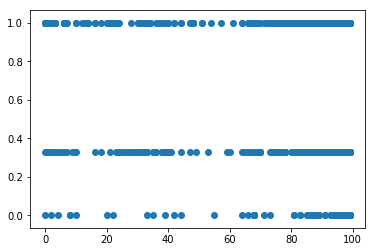

In [8]:
plt.scatter(dataScore.iloc[:,0].tolist(),dataScore.iloc[:,1].tolist())

# VALIDATION

In [5]:
rupPred = RupturaPrediction(X)
rupPred.DESCONHECIDO = xUnknow
rupPred.addLastX(lastX)
rupPred.validate(Ytest, model)
dataScore = rupPred.calculateDataScore()  # passo que define a validacao
#rupPred.plotScore(dataScore)

essa funcao depende muito do formato do Y


In [ ]:
xnext = []
for xBatch, point in zip(X, lastX):
    #print(point)
    print(point.shape)
    xnext.append(np.append(xBatch,[point],axis=0))

In [ ]:
pred = dataScore.score.tolist()
ytrue = dataScore.Inadimplente.tolist()
ytrue = [int(x) for x in ytrue]
modelIndicators = ModelIndicators(version)
modelIndicators.TARGET_SCORE_CUT = 30
modelIndicators.setPredProbs(ytrue,pred)
indic = modelIndicators.allIndicators()
file = open('ruptura-indicators.csv','a+')
file.write('\n' + 'version;' + version + ';' + 'referenceDate;' + referenceDate + '\n')
for i in range(len(indic)):
    file.write(str(indic.index[i]) + ';' + str(indic.iloc[i,0]) + '\n')
file.close()

# ESTATISTICA DESCRITIVA

In [ ]:
allT = [x.split('-') for x in createBatch.titles]
loja = []
prod = []
for t in allT:
    loja.append(t[0])
    prod.append(t[1])
nPontosDeVenda = len(collections.Counter(loja).keys())
nProdutos = len(collections.Counter(prod).keys())
xzao = []
for x in X:
    for xt in x:
        xzao.append(str(xt))
ocorrenciaCounter = collections.Counter(xzao)        